In [1]:
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rcParams['font.family'] = 'IPAexGothic'
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
### データファイルの読込
df_pid = pd.read_csv('./data/00000000_prefecture_id.csv')
df_mig = pd.read_csv('./data/00200523_migration.csv', parse_dates=['datetime'])
df_pop = pd.read_csv('./data/00200241_population.csv', parse_dates=['datetime'])
df_wag = pd.read_csv('./data/00450091_wage.csv', parse_dates=['datetime'])
df_idt = pd.read_csv('./data/00550010_industrial.csv', parse_dates=['datetime'])
df_ret = pd.read_csv('./data/00550020_retail.csv', parse_dates=['datetime'])
pd.set_option("display.max_columns", 100)
df_mig.head(3)

,datetime,prefecture,mig_in,mig_out,mig_internal
0,2005-04-01,北海道,11705,13894,52526
1,2005-04-01,青森県,4230,6603,5525
2,2005-04-01,岩手県,4082,5984,4840


In [3]:
### データの前処理(1):月次データ化
df_mig_month = df_mig

df_list = []
for prefecture in df_pop['prefecture'].unique():
    df_tmp = df_pop[df_pop['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1MS').interpolate()
    df_tmp['prefecture'] = prefecture
    df_tmp.reset_index(inplace=True)
    df_list.append(df_tmp)
df_pop_month = pd.concat(df_list)

df_list = []
for prefecture in df_wag['prefecture'].unique():
    df_tmp = df_wag[df_wag['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1MS').interpolate()
    df_tmp['prefecture'] = prefecture
    df_tmp.reset_index(inplace=True)
    df_list.append(df_tmp)
df_wag_month = pd.concat(df_list)

df_list = []
for prefecture in df_idt['prefecture'].unique():
    df_tmp = df_idt[df_idt['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1MS').interpolate()
    df_tmp['prefecture'] = prefecture
    df_tmp.reset_index(inplace=True)
    df_list.append(df_tmp)
df_idt_month = pd.concat(df_list)

df_list = []
for prefecture in df_ret['prefecture'].unique():
    df_tmp = df_ret[df_ret['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1MS').interpolate()
    df_tmp['prefecture'] = prefecture
    df_tmp.reset_index(inplace=True)
    df_list.append(df_tmp)
df_ret_month = pd.concat(df_list)

In [4]:
### データの前処理(2):データ結合
dt_all_start = datetime.datetime.strptime('2008-01-01', '%Y-%m-%d')
dt_all_end = datetime.datetime.strptime('2014-01-01', '%Y-%m-%d')
df_all = df_mig_month[((df_mig_month['datetime'] >= dt_all_start) & (df_mig_month['datetime'] <= dt_all_end))]
df_all = df_all.merge(df_pop_month, how='left')
df_all = df_all.merge(df_wag_month, how='left')
df_all = df_all.merge(df_idt_month, how='left')
df_all = df_all.merge(df_ret_month, how='left')
df_all.dropna(inplace=True)
df_all.reset_index(drop=True, inplace=True)
df_all.head(3)

,datetime,prefecture,mig_in,mig_out,mig_internal,pop_male,pop_female,pop_sum,pop_households,wag_age,wag_salary,wag_bonus,wag_workers,idt_offices,idt_employees,idt_salaries,idt_costs,idt_sales,ret_offices,ret_employees,ret_sales
0,2008-01-01,北海道,2310,3525,10230,2648735.0,2923035.0,5571770.0,2618005.0,41.6,299300.0,767600.0,814020.0,6618.0,185625.0,6.255000e+11,3.893719e+12,5.917424e+12,58041.8,462157.4,1.735049e+13
1,2008-01-01,青森県,916,1464,1042,680654.0,749889.0,1430543.0,565347.0,40.9,247600.0,552900.0,204810.0,1829.0,63036.0,1.946430e+11,9.221590e+11,1.649446e+12,18200.4,117196.6,3.215000e+12
2,2008-01-01,岩手県,924,1130,1161,657304.0,709348.0,1366652.0,499351.0,41.9,255400.0,547300.0,213920.0,2696.0,98655.0,3.379460e+11,1.676235e+12,2.528404e+12,17462.2,108503.2,3.121844e+12


In [5]:
### データの前処理(3):ラグデータ化
df_list = []
for prefecture in df_all['prefecture'].unique():
    df_tmp = df_all[df_all['prefecture'] == prefecture]
    df_tmp = df_tmp.shift(1)
    df_list.append(df_tmp)
df_all_lag1 = pd.concat(df_list)
df_all_lag1.rename(columns=lambda x: x + '_lag1', inplace=True)
df_all_lag = pd.concat([df_all.iloc[:, 0:3], df_all_lag1.iloc[:,2:24]], axis=1)
df_all_lag.dropna(inplace=True)
df_all_lag.reset_index(drop=True, inplace=True)
df_all_lag.head(3)

,datetime,prefecture,mig_in,mig_in_lag1,mig_out_lag1,mig_internal_lag1,pop_male_lag1,pop_female_lag1,pop_sum_lag1,pop_households_lag1,wag_age_lag1,wag_salary_lag1,wag_bonus_lag1,wag_workers_lag1,idt_offices_lag1,idt_employees_lag1,idt_salaries_lag1,idt_costs_lag1,idt_sales_lag1,ret_offices_lag1,ret_employees_lag1,ret_sales_lag1
0,2008-02-01,北海道,2406,2310.0,3525.0,10230.0,2648735.0,2923035.0,5571770.0,2618005.0,41.6,299300.0,767600.0,814020.0,6618.0,185625.0,6.255000e+11,3.893719e+12,5.917424e+12,58041.8,462157.4,1.735049e+13
1,2008-02-01,青森県,1016,916.0,1464.0,1042.0,680654.0,749889.0,1430543.0,565347.0,40.9,247600.0,552900.0,204810.0,1829.0,63036.0,1.946430e+11,9.221590e+11,1.649446e+12,18200.4,117196.6,3.215000e+12
2,2008-02-01,岩手県,1057,924.0,1130.0,1161.0,657304.0,709348.0,1366652.0,499351.0,41.9,255400.0,547300.0,213920.0,2696.0,98655.0,3.379460e+11,1.676235e+12,2.528404e+12,17462.2,108503.2,3.121844e+12


In [6]:
### データの前処理(3-2):位置ラグデータ化
df_all_loclag = df_all_lag.merge(df_pid, how='left')
df_list = []
for k_datetime in df_all_loclag['datetime'].unique():
    df_tmp = df_all_loclag[df_all_loclag['datetime'] == k_datetime]
    df_tmp = df_tmp.shift(1)
    df_list.append(df_tmp)
df_all_loclag1 = pd.concat(df_list)
df_all_loclag1.rename(columns=lambda x: x + '_loclag1', inplace=True)
df_all_loclag = pd.concat([df_all_loclag, df_all_loclag1.iloc[:,2:24]], axis=1)
df_all_loclag.dropna(inplace=True)
df_all_loclag.drop(['prefecture_id', 'prefecture_id_loclag1', 'mig_in_loclag1'], axis=1, inplace=True)
df_all_loclag.reset_index(drop=True, inplace=True)
df_all_loclag.head(3)

,datetime,prefecture,mig_in,mig_in_lag1,mig_out_lag1,mig_internal_lag1,pop_male_lag1,pop_female_lag1,pop_sum_lag1,pop_households_lag1,wag_age_lag1,wag_salary_lag1,wag_bonus_lag1,wag_workers_lag1,idt_offices_lag1,idt_employees_lag1,idt_salaries_lag1,idt_costs_lag1,idt_sales_lag1,ret_offices_lag1,ret_employees_lag1,ret_sales_lag1,mig_in_lag1_loclag1,mig_out_lag1_loclag1,mig_internal_lag1_loclag1,pop_male_lag1_loclag1,pop_female_lag1_loclag1,pop_sum_lag1_loclag1,pop_households_lag1_loclag1,wag_age_lag1_loclag1,wag_salary_lag1_loclag1,wag_bonus_lag1_loclag1,wag_workers_lag1_loclag1,idt_offices_lag1_loclag1,idt_employees_lag1_loclag1,idt_salaries_lag1_loclag1,idt_costs_lag1_loclag1,idt_sales_lag1_loclag1,ret_offices_lag1_loclag1,ret_employees_lag1_loclag1,ret_sales_lag1_loclag1
0,2008-02-01,青森県,1016,916.0,1464.0,1042.0,680654.0,749889.0,1430543.0,565347.0,40.9,247600.0,552900.0,204810.0,1829.0,63036.0,1.946430e+11,9.221590e+11,1.649446e+12,18200.4,117196.6,3.215000e+12,2310.0,3525.0,10230.0,2648735.0,2923035.0,5571770.0,2618005.0,41.6,299300.0,767600.0,814020.0,6618.0,185625.0,6.255000e+11,3.893719e+12,5.917424e+12,58041.8,462157.4,1.735049e+13
1,2008-02-01,岩手県,1057,924.0,1130.0,1161.0,657304.0,709348.0,1366652.0,499351.0,41.9,255400.0,547300.0,213920.0,2696.0,98655.0,3.379460e+11,1.676235e+12,2.528404e+12,17462.2,108503.2,3.121844e+12,916.0,1464.0,1042.0,680654.0,749889.0,1430543.0,565347.0,40.9,247600.0,552900.0,204810.0,1829.0,63036.0,1.946430e+11,9.221590e+11,1.649446e+12,18200.4,117196.6,3.215000e+12
2,2008-02-01,宮城県,2546,2336.0,2526.0,3485.0,1135696.0,1199178.0,2334874.0,891573.0,41.1,301700.0,739500.0,332470.0,3467.0,124885.0,4.648840e+11,2.215718e+12,3.538700e+12,28799.6,226099.8,1.036777e+13,924.0,1130.0,1161.0,657304.0,709348.0,1366652.0,499351.0,41.9,255400.0,547300.0,213920.0,2696.0,98655.0,3.379460e+11,1.676235e+12,2.528404e+12,17462.2,108503.2,3.121844e+12


In [7]:
### データの前処理(4):データスケーリング
df_all_list = list()
df_all_list.append(df_all_loclag['datetime'])
df_all_list.append(df_all_loclag['prefecture'])
df_all_list.append(df_all_loclag['mig_in'])
for i in range(3, df_all_loclag.shape[1]):
    sc = StandardScaler()
    a = df_all_loclag.iloc[:, i]
    a = np.array(a, dtype='float32').reshape(-1, 1)
    sc.partial_fit(a)
    a = sc.transform(a)
    a = pd.DataFrame(a, columns=[df_all_loclag.columns[i]])
    a = df_all_list.append(a)
df_all_sc = pd.concat(df_all_list, 1)
df_all_sc.head(3)

,datetime,prefecture,mig_in,mig_in_lag1,mig_out_lag1,mig_internal_lag1,pop_male_lag1,pop_female_lag1,pop_sum_lag1,pop_households_lag1,wag_age_lag1,wag_salary_lag1,wag_bonus_lag1,wag_workers_lag1,idt_offices_lag1,idt_employees_lag1,idt_salaries_lag1,idt_costs_lag1,idt_sales_lag1,ret_offices_lag1,ret_employees_lag1,ret_sales_lag1,mig_in_lag1_loclag1,mig_out_lag1_loclag1,mig_internal_lag1_loclag1,pop_male_lag1_loclag1,pop_female_lag1_loclag1,pop_sum_lag1_loclag1,pop_households_lag1_loclag1,wag_age_lag1_loclag1,wag_salary_lag1_loclag1,wag_bonus_lag1_loclag1,wag_workers_lag1_loclag1,idt_offices_lag1_loclag1,idt_employees_lag1_loclag1,idt_salaries_lag1_loclag1,idt_costs_lag1_loclag1,idt_sales_lag1_loclag1,ret_offices_lag1_loclag1,ret_employees_lag1_loclag1,ret_sales_lag1_loclag1
0,2008-02-01,青森県,1016,-0.467481,-0.462009,-0.551097,-0.475645,-0.463353,-0.469594,-0.452992,-1.430446,-1.483294,-1.072031,-0.414887,-0.660378,-0.680662,-0.709240,-0.663040,-0.67205,-0.418737,-0.394474,-0.285350,-0.277332,-0.126353,0.760886,1.008393,1.155877,1.082926,1.183504,-0.349294,0.095950,0.341795,0.620967,0.410367,0.143269,-0.126595,-0.021589,-0.058813,0.991556,0.735204,0.257712
1,2008-02-01,岩手県,1057,-0.466354,-0.518068,-0.532865,-0.493734,-0.494496,-0.494245,-0.507384,0.199602,-1.241332,-1.109442,-0.398982,-0.462852,-0.435272,-0.509966,-0.495726,-0.54209,-0.445621,-0.423665,-0.289006,-0.473688,-0.471467,-0.559386,-0.503615,-0.493802,-0.498840,-0.483453,-1.510550,-1.556527,-1.162745,-0.438962,-0.687583,-0.709786,-0.730807,-0.685336,-0.694689,-0.447536,-0.418621,-0.297465
2,2008-02-01,宮城県,2546,-0.267446,-0.283762,-0.176800,-0.123120,-0.118214,-0.120688,-0.184126,-1.104441,0.194927,0.174581,-0.191996,-0.287197,-0.254566,-0.333448,-0.376025,-0.39271,-0.032732,-0.028788,-0.004599,-0.472561,-0.527396,-0.542286,-0.521554,-0.524578,-0.523243,-0.537048,0.148394,-1.307217,-1.201988,-0.423112,-0.488810,-0.461925,-0.529846,-0.516900,-0.563735,-0.474200,-0.447699,-0.301124


In [8]:
### データ前処理(5):学習用データ化
dt_train_start = datetime.datetime.strptime('2008-02-01', '%Y-%m-%d')
dt_train_end = datetime.datetime.strptime('2012-12-01', '%Y-%m-%d')
dt_validation_start = datetime.datetime.strptime('2013-01-01', '%Y-%m-%d')
dt_validation_end = datetime.datetime.strptime('2013-12-01', '%Y-%m-%d')
df_train = df_all_sc[((df_all_sc['datetime'] >= dt_train_start) & (df_all_sc['datetime'] <= dt_train_end))]
df_train_rand = df_train.reindex(np.random.permutation(df_train.index)).reset_index(drop=True)
train_x = np.array(df_train_rand.iloc[:, 3:].as_matrix(), dtype='float32')
train_y = np.array(df_train_rand.iloc[:, 2].as_matrix(), dtype='float32')
df_validation = df_all_sc[((df_all_sc['datetime'] >= dt_validation_start) & (df_all_sc['datetime'] <= dt_validation_end))]
df_validation_rand = df_validation.reindex(np.random.permutation(df_validation.index)).reset_index(drop=True)
validation_x = np.array(df_validation_rand.iloc[:, 3:].as_matrix(), dtype='float32')
validation_y = np.array(df_validation_rand.iloc[:, 2].as_matrix(), dtype='float32')

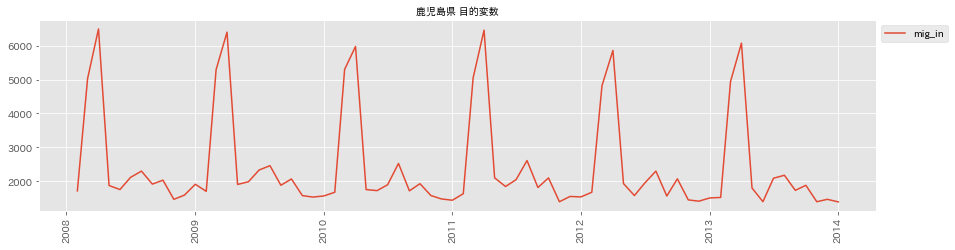

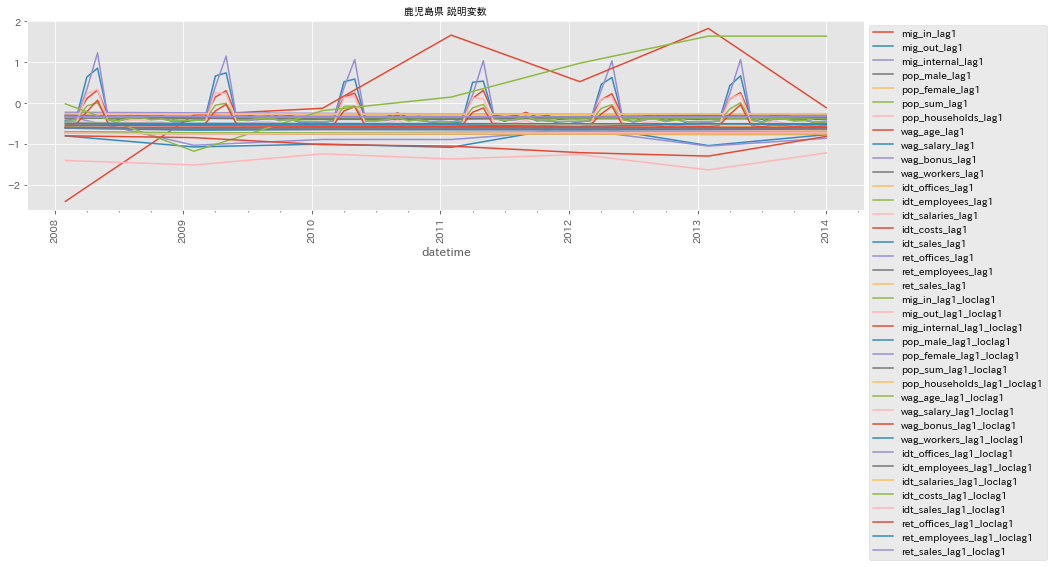

In [9]:
### 事前のデータ確認(サンプル)
prefecture = '鹿児島県'
df_tmp = df_all_sc[df_all_sc['prefecture'] == prefecture]
x = df_tmp['datetime']
y = df_tmp['mig_in']
fig = plt.figure(figsize=(15,3.5))
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title(prefecture + ' 目的変数', fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

df_tmp.set_index('datetime', inplace=True)
df_tmp = df_tmp.iloc[:, 2:]
fig = plt.figure(figsize=(15,3.5))
ax = fig.add_subplot(111)
df_tmp.plot(ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title(prefecture + ' 説明変数', fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import datasets
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [11]:
### DL学習設定
n_in = df_all_sc.shape[1] -3 # 19
n_hiddens = [200, 200]
n_out = 1
activation = 'relu'

def weight_variable(shape, name=None):
    return np.sqrt(2000.0 / shape[0]) * np.random.normal(size=shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)

model = Sequential()
for i, input_dim in enumerate(([n_in] + n_hiddens)[:-1]):
    model.add(Dense(n_hiddens[i], input_dim=input_dim,
                    kernel_initializer=weight_variable))
    model.add(BatchNormalization())
    model.add(Activation(activation))

model.add(Dense(n_out, kernel_initializer=weight_variable))
model.add(Activation('relu'))
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999),
              metrics=['mae'])

### DL学習
epochs = 500
batch_size = 30
hist = model.fit(train_x, train_y, epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(validation_x, validation_y),
                 callbacks=[early_stopping])

Train on 2714 samples, validate on 552 samples
Epoch 1/500
2714/2714 [==============================] - 1s 334us/step - loss: 64339100.4473 - mean_absolute_error: 4035.1514 - val_loss: 55338952.7826 - val_mean_absolute_error: 3737.4731
Epoch 2/500
2714/2714 [==============================] - 0s 98us/step - loss: 52560658.8040 - mean_absolute_error: 3494.8010 - val_loss: 40452024.1902 - val_mean_absolute_error: 3117.6174
Epoch 3/500
2714/2714 [==============================] - 0s 101us/step - loss: 39926012.3001 - mean_absolute_error: 2727.8943 - val_loss: 28729315.3220 - val_mean_absolute_error: 2253.7159
Epoch 4/500
2714/2714 [==============================] - 0s 101us/step - loss: 30748625.4413 - mean_absolute_error: 2076.1342 - val_loss: 20087556.9347 - val_mean_absolute_error: 1628.8335
Epoch 5/500
2714/2714 [==============================] - 0s 108us/step - loss: 23601133.9259 - mean_absolute_error: 1745.3887 - val_loss: 16000013.6081 - val_mean_absolute_error: 1386.1123
Epoch 6/5

Epoch 44/500
2714/2714 [==============================] - 0s 106us/step - loss: 14852361.4447 - mean_absolute_error: 1796.0353 - val_loss: 12666906.5078 - val_mean_absolute_error: 1400.0177
Epoch 45/500
2714/2714 [==============================] - 0s 100us/step - loss: 14468262.8966 - mean_absolute_error: 1751.3749 - val_loss: 11844768.3122 - val_mean_absolute_error: 1410.9257
Epoch 46/500
2714/2714 [==============================] - 0s 104us/step - loss: 14335214.5942 - mean_absolute_error: 1739.3606 - val_loss: 11711836.8872 - val_mean_absolute_error: 1480.6901
Epoch 47/500
2714/2714 [==============================] - 0s 106us/step - loss: 14763453.3318 - mean_absolute_error: 1773.3342 - val_loss: 14118764.1026 - val_mean_absolute_error: 1493.3502
Epoch 48/500
2714/2714 [==============================] - 0s 104us/step - loss: 14363998.1100 - mean_absolute_error: 1760.8534 - val_loss: 12634011.8366 - val_mean_absolute_error: 1501.6038
Epoch 49/500
2714/2714 [==========================

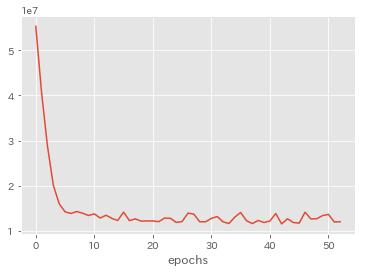

552/552 [==============================] - 0s 59us/step
[12022208.663043479, 1544.3177746758945]


In [12]:
### 学習過程の確認
val_loss = hist.history['val_loss']
fig = plt.figure()
plt.plot(range(len(val_loss)), val_loss, label='loss')
plt.xlabel('epochs')
plt.show()

print(model.evaluate(validation_x, validation_y))

In [13]:
### モデルを用いた予測データの作成
train_x = np.array(df_train.iloc[:, 3:].as_matrix(), dtype='float32')
validation_x = np.array(df_validation.iloc[:, 3:].as_matrix(), dtype='float32')
pred_train = model.predict_proba(train_x) 
pred_validation = model.predict_proba(validation_x)
pred = np.concatenate([pred_train, pred_validation])
df_pred = pd.DataFrame(pred, columns=['mig_in_pred'])
df_pred = pd.concat([df_all_sc.iloc[:, 0:3], df_pred], axis=1)
df_pred.head(3)

,datetime,prefecture,mig_in,mig_in_pred
0,2008-02-01,青森県,1016,1512.558960
1,2008-02-01,岩手県,1057,986.591187
2,2008-02-01,宮城県,2546,3282.027832


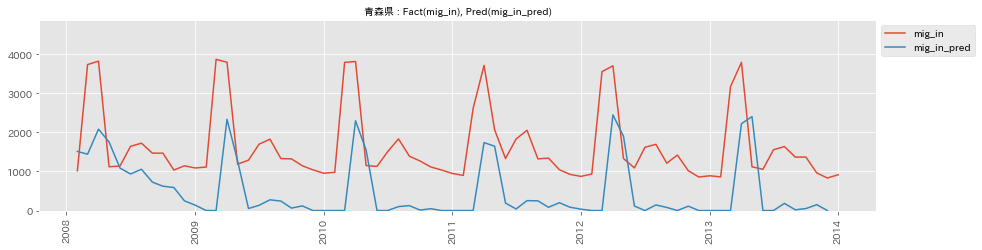

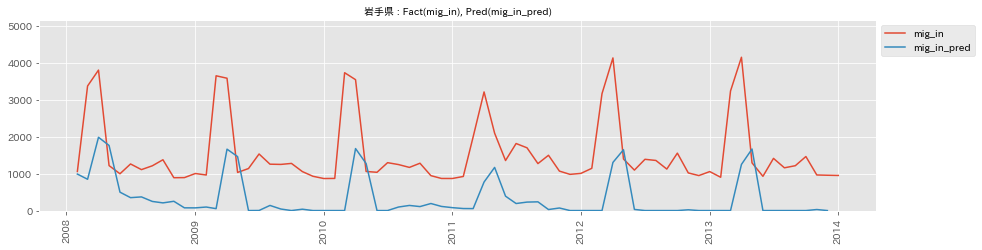

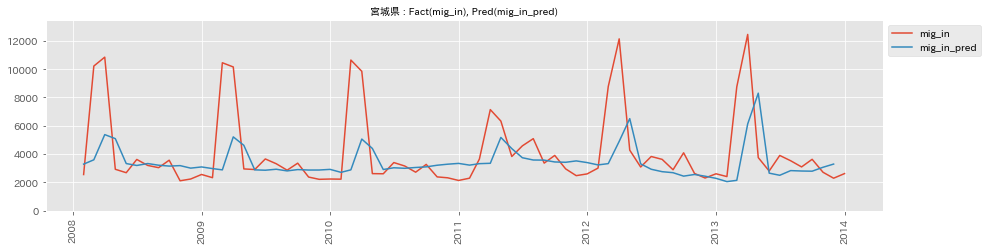

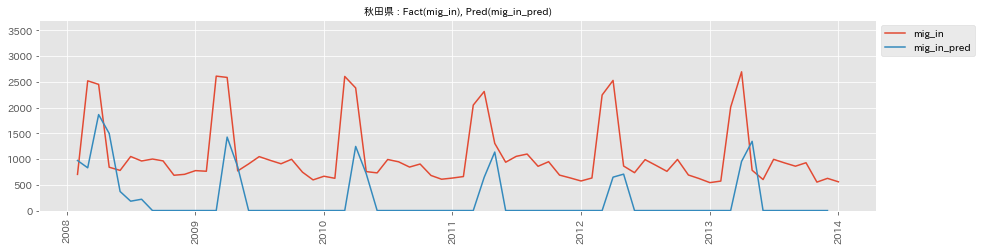

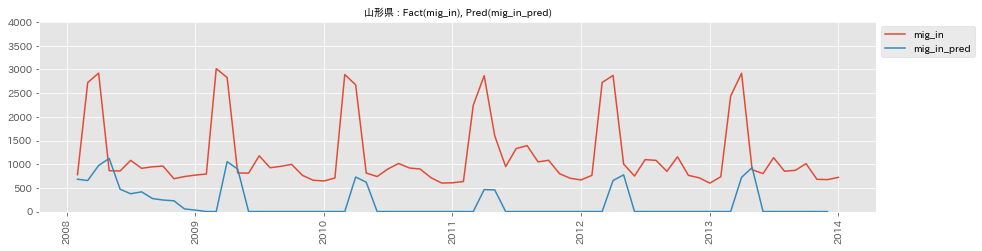

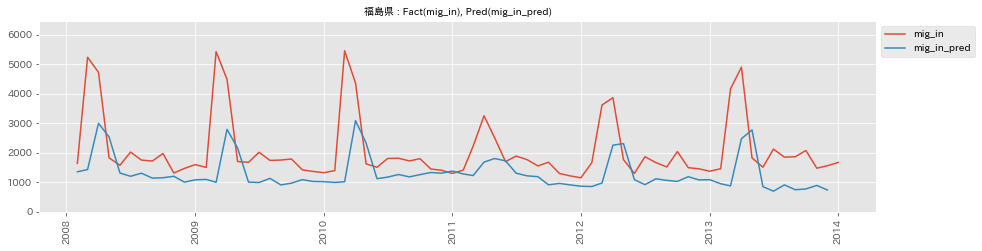

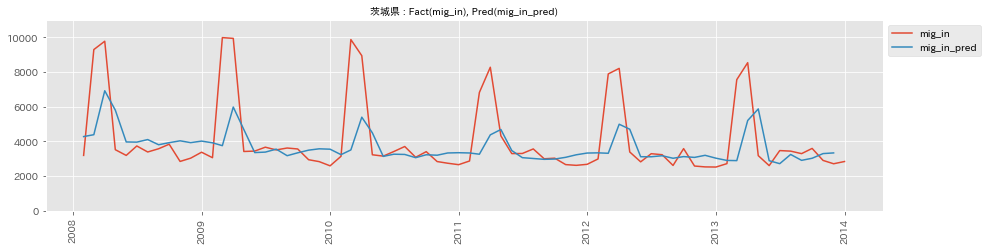

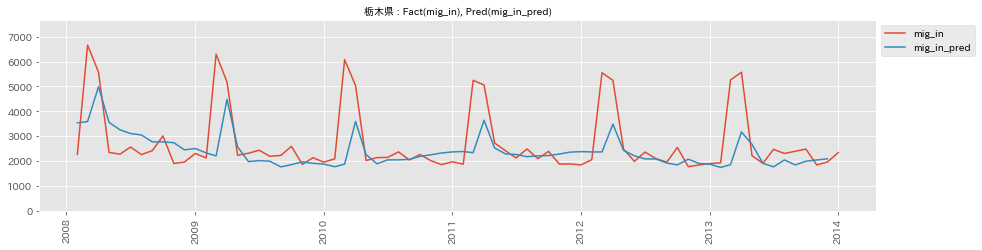

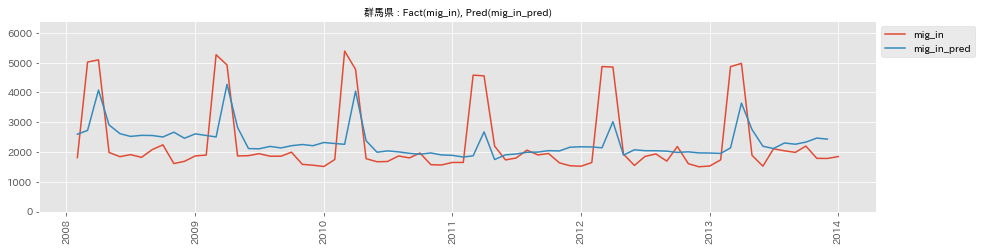

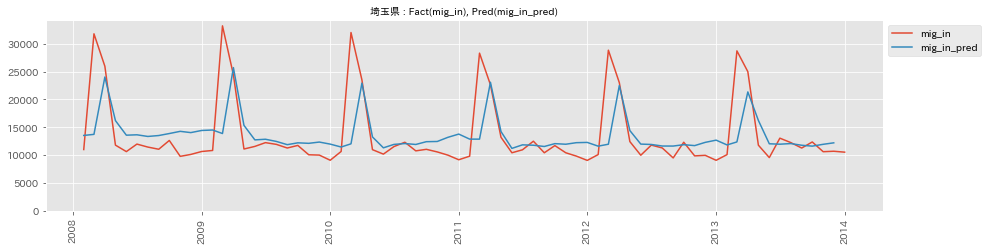

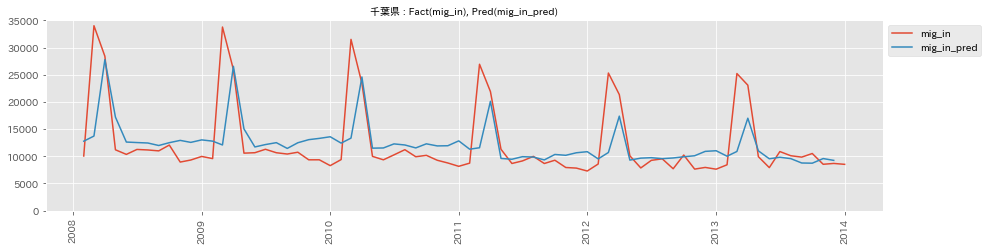

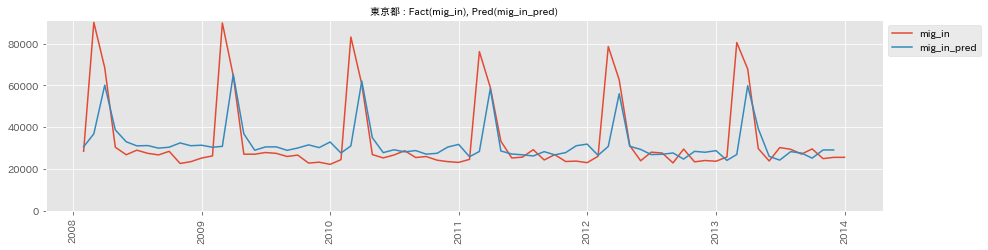

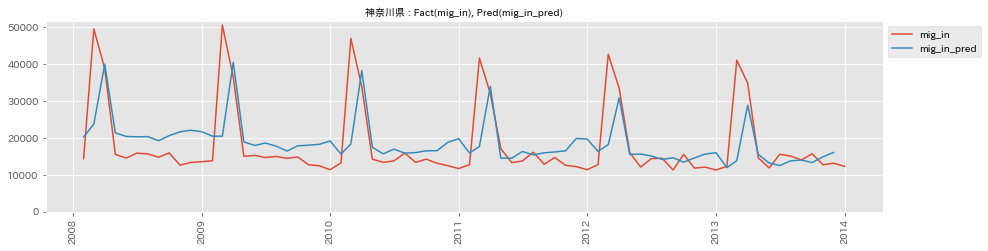

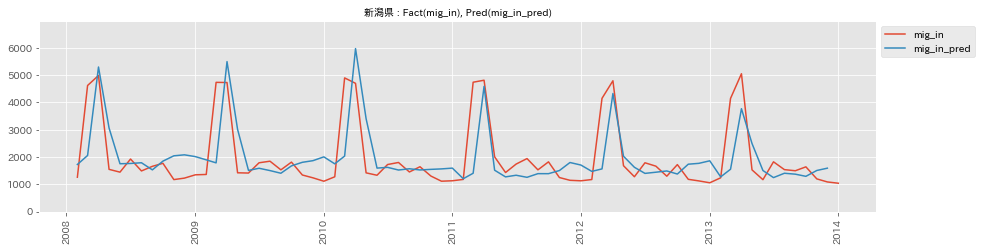

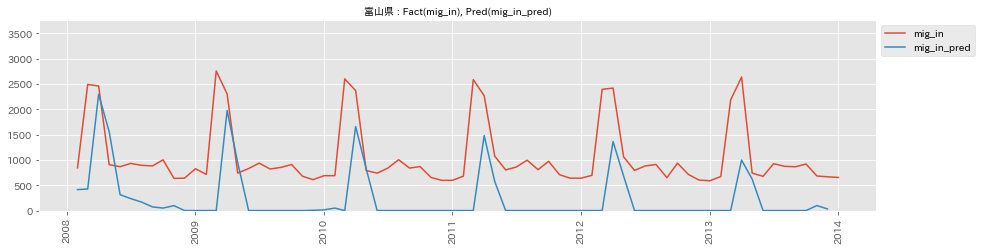

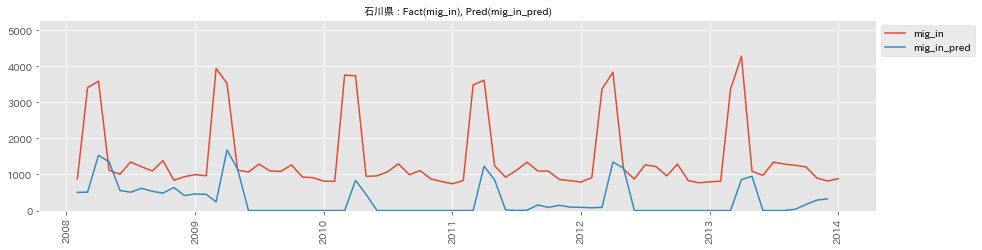

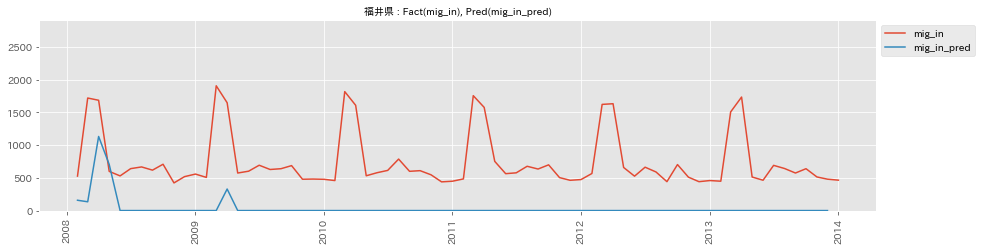

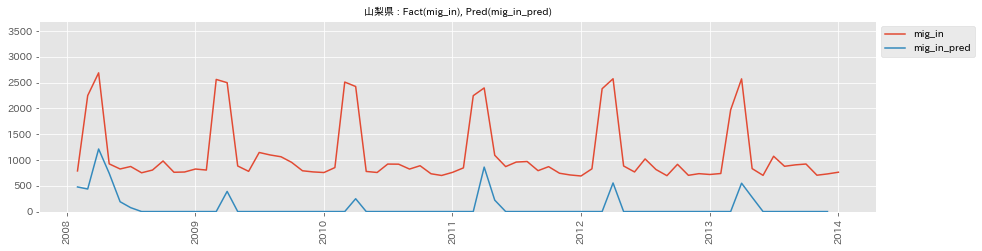

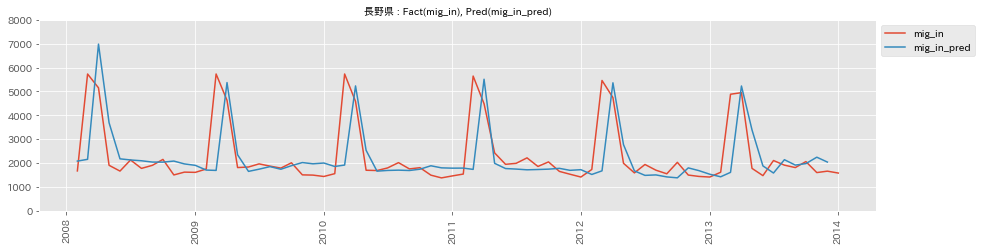

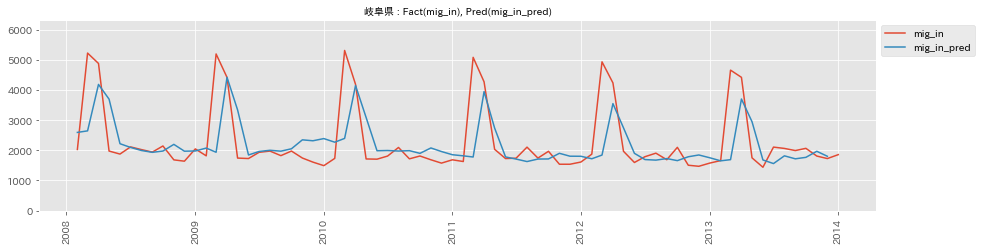

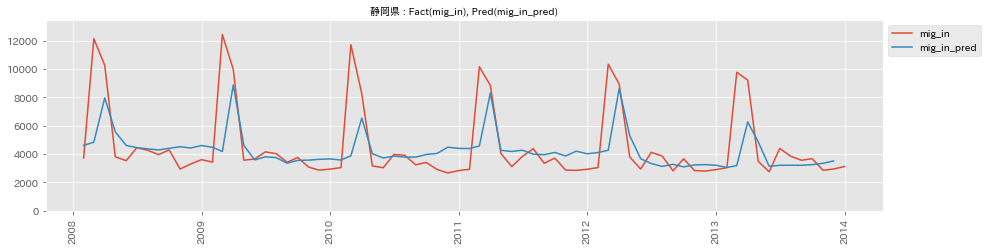

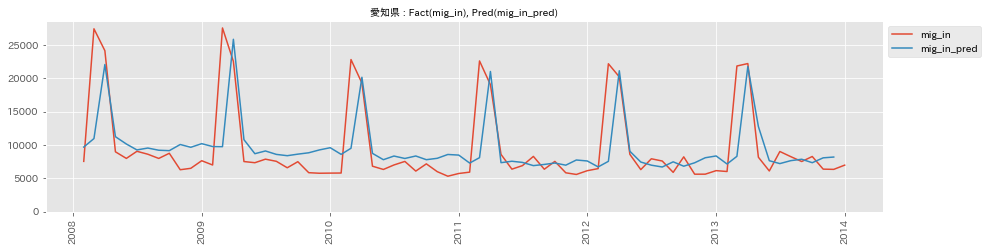

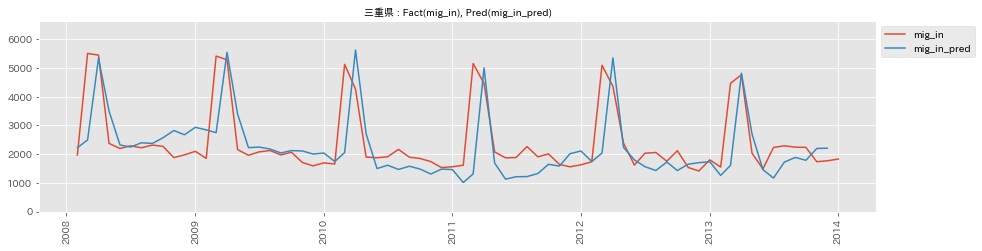

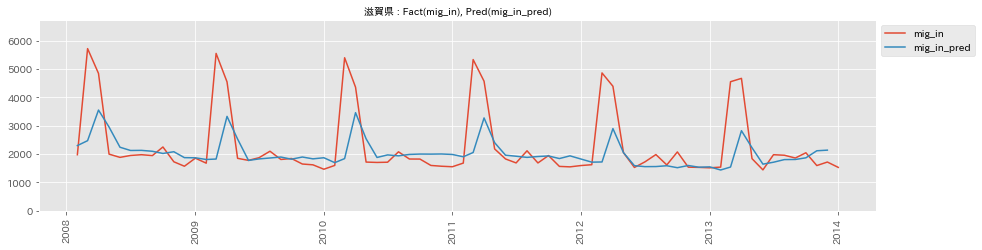

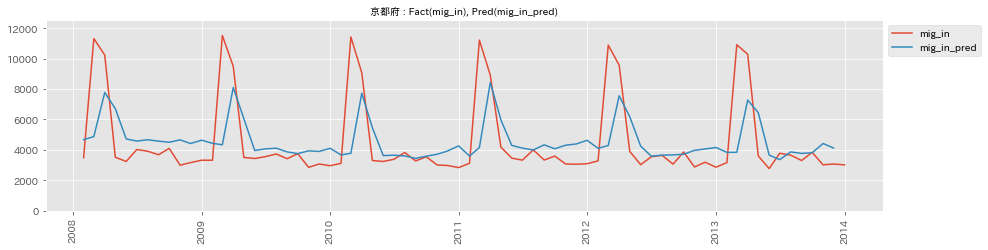

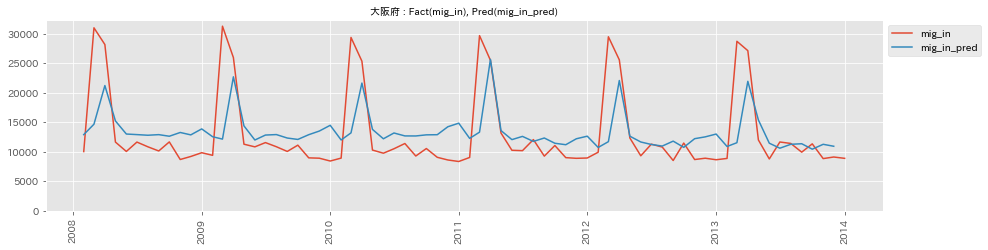

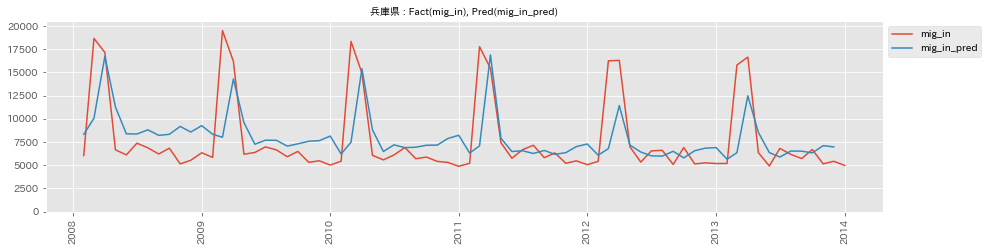

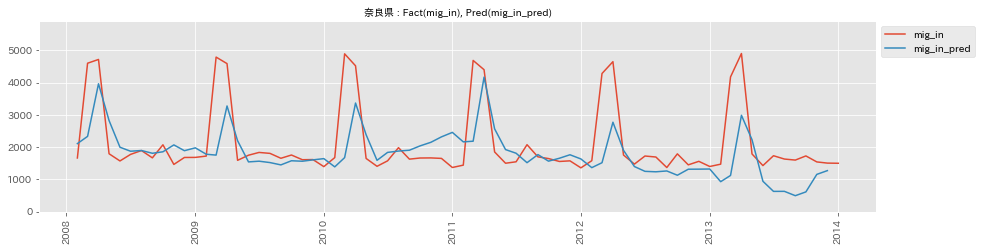

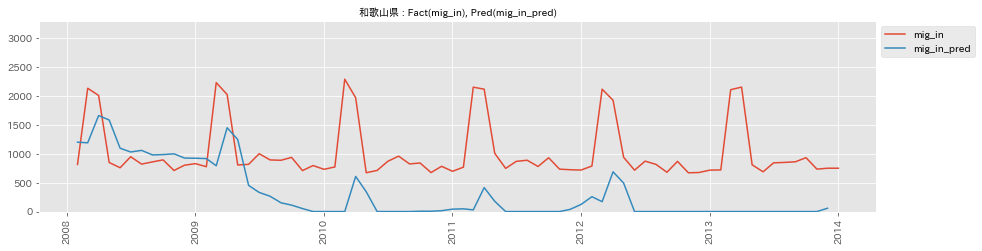

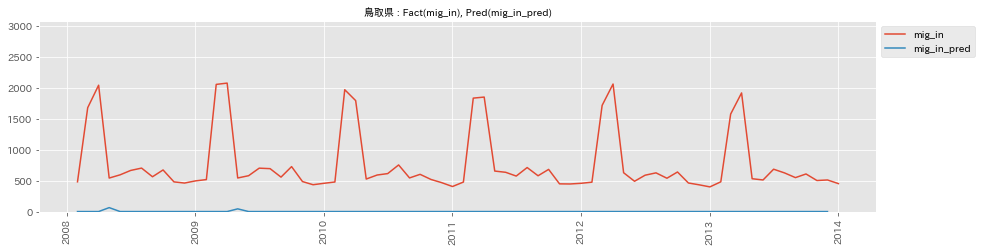

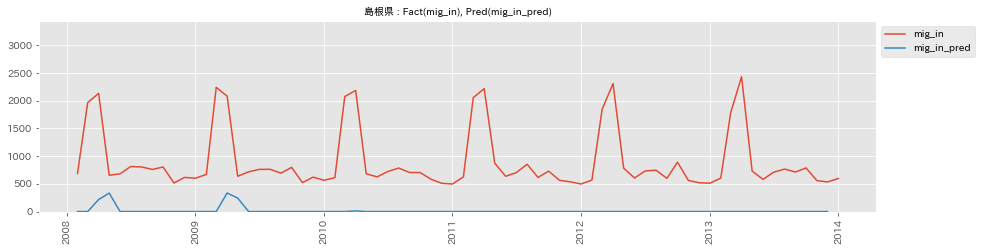

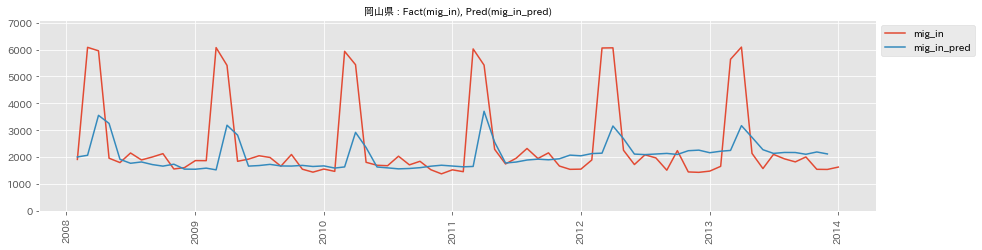

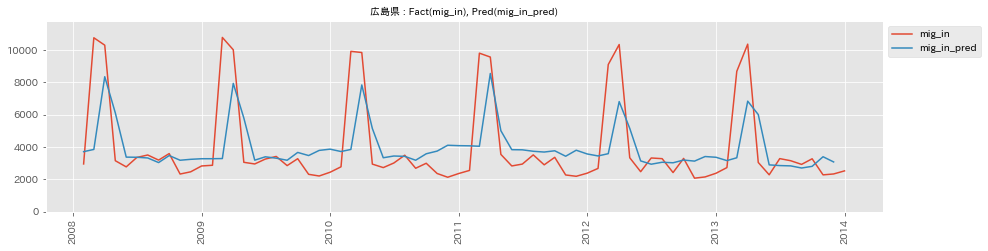

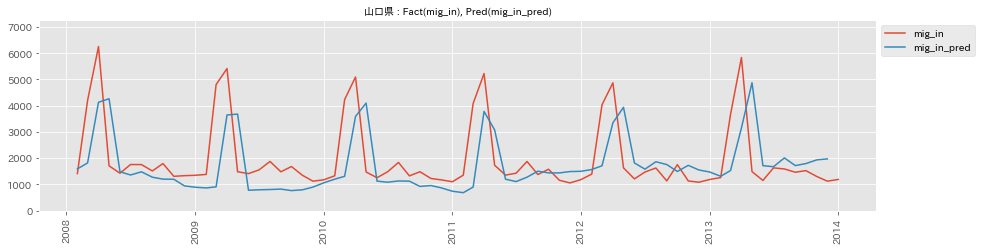

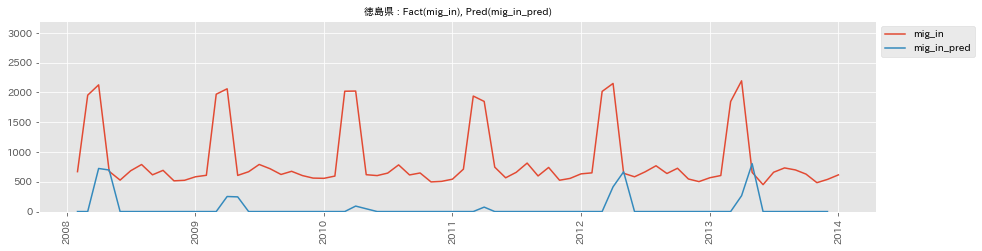

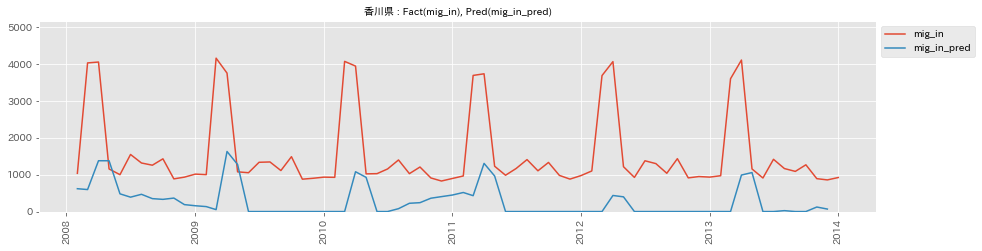

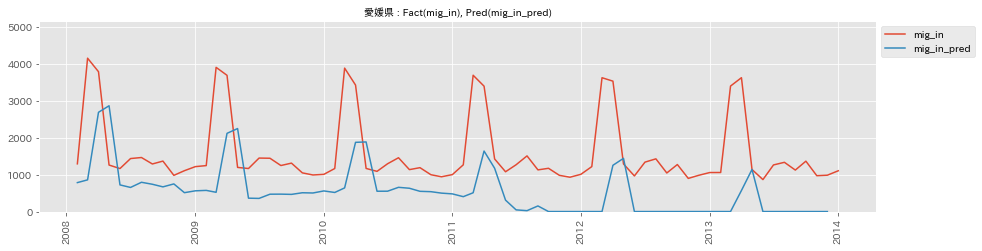

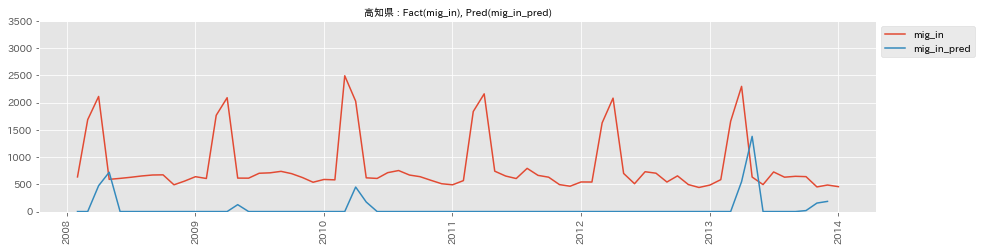

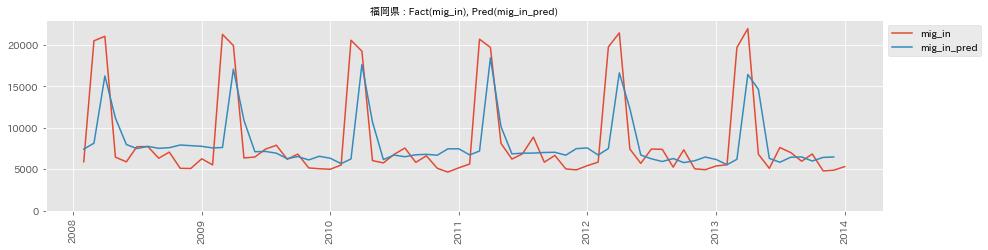

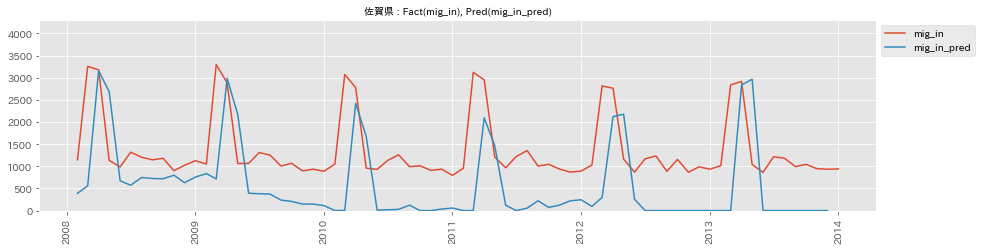

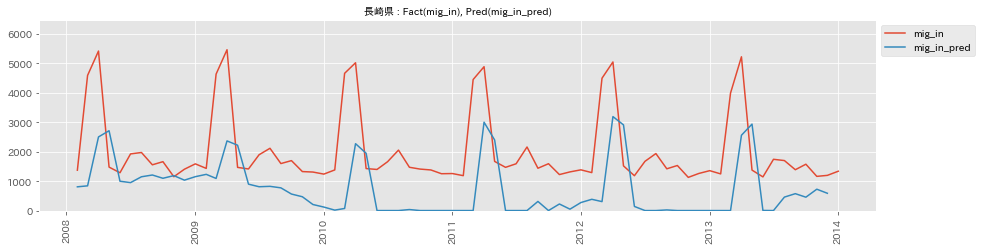

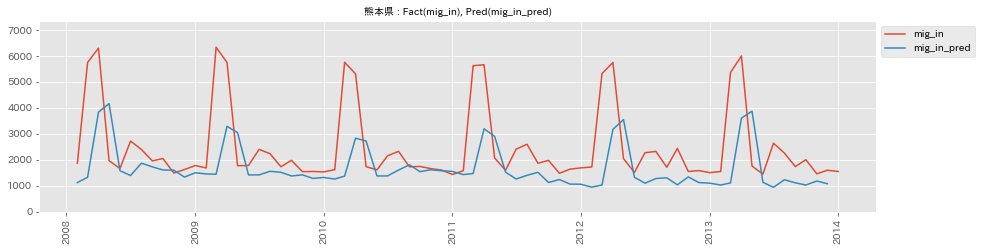

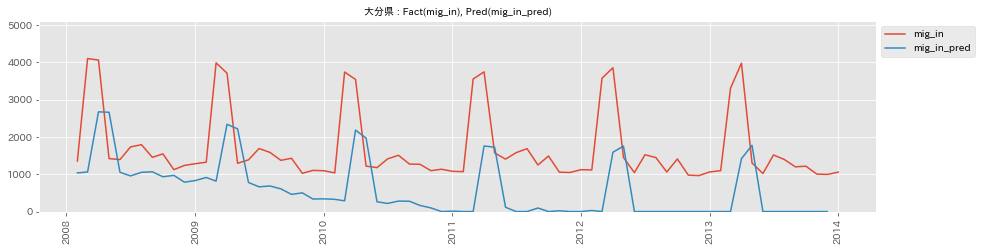

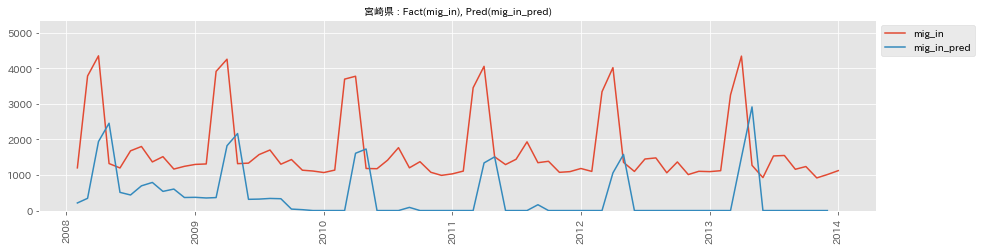

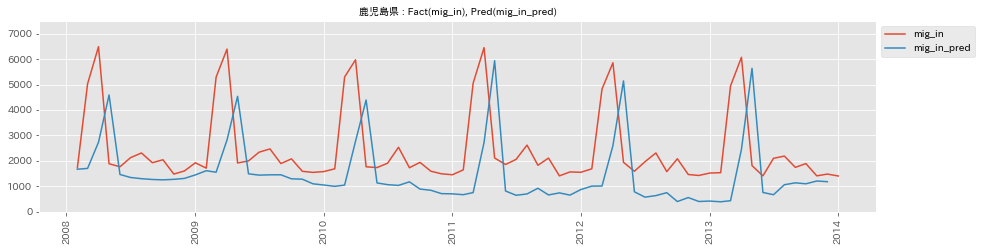

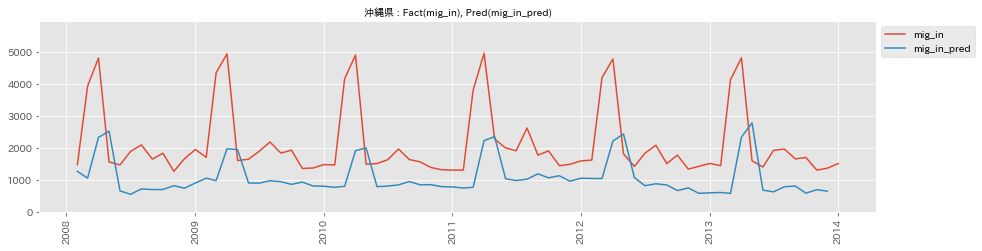

In [14]:
### 予測データの確認(可視化)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'IPAexGothic'
for prefecture in df_pred['prefecture'].unique():
    df_tmp = df_pred[df_pred['prefecture'] == prefecture]
    x = df_tmp['datetime']
    y1 = df_tmp['mig_in']
    y2 = df_tmp['mig_in_pred']
    fig = plt.figure(figsize=(15,3.5))
    ax = fig.add_subplot(111)
    ax.plot(x, y1)
    ax.plot(x, y2)
    plt.ylim(0, max(y1.max(), y2.max()) + 1000)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.set_title(prefecture + ' : Fact(mig_in), Pred(mig_in_pred)', fontsize=10)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()